## Face Emotion Classfication with BDR based on ResNet

## Step 0: Download and import all required libraries

To run this notebook, you need to have the following packages installed:
-  torch: a python deep learning package(CUDA version 10.0)
-  pandas: a python data analysis package; if you are familiar with numpy, you can use numpy instead
-  matplotlib: a python package for data visualization
-  sklearn: a python package for data mining and data analysis
-  albumentations: a python package for image transformations
-  torchvision: a python package consists of popular datasets, model architectures, and common image transformations for computer vision
-  cv2: opencv for image processing
-  numpy: a python data analysis package;

To install pytorch, please follow the __[instructions on their website](http://pytorch.org/)__. Please ensure you install version 0.4 or above. (CUDA version 10.0)

To install pandas, in your terminal, type `pip3 install pandas` for python 3.

To install matplotlib, in your terminal, type `pip3 install matplotlib` for python 3.

To install sklearn, in your terminal, type `pip3 install -U scikit-learn` for python 3.

To install albumentations, in your terminal, type `pip3 install albumentations` for python 3.

To install torchvision, in your terminal, type `pip3 install torchvision` for python 3.

To install cv2, in your terminal, type `pip3 install opencv-python` for python 3.

To install numpy, in your terminal, type `pip3 install numpy` for python 3.

In [1]:
# import libraries

import os
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torchvision
import torchvision.transforms as transforms
import albumentations
from albumentations import torch as AT
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
# from PIL import Image

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision

import cv2
import numpy as np

import matplotlib.pyplot as plt


## Step 1: Load and setup training  and validation dataset 
generate train_labels.csv and val_labels.csv 
-  train_labels.csv = dataset for training purpose
-  val_labels.csv  = dataset for validation and testing purpose 

In [28]:
# dataset process

# labels generate
train_img_angry = os.listdir("Train/Train_Aligned_Faces/Angry")
train_img_disgust = os.listdir("Train/Train_Aligned_Faces/Disgust")
train_img_fear = os.listdir("Train/Train_Aligned_Faces/Fear")
train_img_happy = os.listdir("Train/Train_Aligned_Faces/Happy")
train_img_Neutral = os.listdir("Train/Train_Aligned_Faces/Neutral")
train_img_sad = os.listdir("Train/Train_Aligned_Faces/Sad")
train_img_surprise = os.listdir("Train/Train_Aligned_Faces/Surprise")
train_img  = [train_img_angry, train_img_disgust, train_img_fear, 
              train_img_happy, train_img_Neutral, train_img_sad, train_img_surprise]

val_img_angry = os.listdir("Val/Val_Aligned_Faces_new/Val_Aligned_Faces/Angry")
val_img_disgust = os.listdir("Val/Val_Aligned_Faces_new/Val_Aligned_Faces/Disgust")
val_img_fear = os.listdir("Val/Val_Aligned_Faces_new/Val_Aligned_Faces/Fear")
val_img_happy = os.listdir("Val/Val_Aligned_Faces_new/Val_Aligned_Faces/Happy")
val_img_Neutral = os.listdir("Val/Val_Aligned_Faces_new/Val_Aligned_Faces/Neutral")
val_img_sad = os.listdir("Val/Val_Aligned_Faces_new/Val_Aligned_Faces/Sad")
val_img_surprise = os.listdir("Val/Val_Aligned_Faces_new/Val_Aligned_Faces/Surprise")
val_img  = [val_img_angry, val_img_disgust, val_img_fear, 
              val_img_happy, val_img_Neutral, val_img_sad, val_img_surprise]

def labels_generator(train_img):
    """generate the labels for the dataset"""
    labels = []
    for i in range(len(train_img)):
        label = []
        for j in range(len(train_img[i])):
            label.append(i)
        labels.append(label)
    return labels

def list_extend(list):
    """combine the list"""
    new = []
    for i in range(len(list)):
        new = new + list[i]
    return new
    
train_labels = labels_generator(train_img)
val_labels = labels_generator(val_img)
# print(labels_generator(train_img))

# generate the train.csv 
train_img_extend = list_extend(train_img)
train_labels_extend = list_extend(train_labels)
train_dit = {"id":train_img_extend, "label":train_labels_extend}
train_df = pd.DataFrame(train_dit)
train_df.to_csv('./train_labels.csv',columns=['id','label'],sep=',')

# generate the val.csv
val_img_extend = list_extend(val_img)
val_labels_extend = list_extend(val_labels)
val_dit = {"id":val_img_extend, "label":val_labels_extend}
val_df = pd.DataFrame(val_dit)
val_df.to_csv('./val_labels.csv',columns=['id','label'],sep=',')

## Step 2: split validation dataset into new validation set and test set

In [3]:
# labels distribution and test,val division


# train labels
t_labels = pd.read_csv('train_labels.csv')
print(t_labels.label.value_counts())
print("training set labels distribution")
print("------------------------")
v_labels = pd.read_csv('val_labels.csv')
print(v_labels.label.value_counts())
print("origin validation set labels distribution")
print("------------------------")
val, test = train_test_split(v_labels, stratify=v_labels.label, test_size=0.5)
print(val.label.value_counts())
print("validation set labels distribution")
print("------------------------")
print(test.label.value_counts())
print("test set labels distribution")
print("------------------------")


3    184
0    178
5    161
4    144
6     94
2     78
1     52
Name: label, dtype: int64
training set labels distribution
------------------------
4    84
0    77
5    73
3    72
6    56
2    46
1    23
Name: label, dtype: int64
origin validation set labels distribution
------------------------
4    42
0    38
5    36
3    36
6    28
2    23
1    12
Name: label, dtype: int64
validation set labels distribution
------------------------
4    42
0    39
5    37
3    36
6    28
2    23
1    11
Name: label, dtype: int64
test set labels distribution
------------------------


## Step 3: generate dataset and dataloader  

In [4]:
# generate dataloader
train_img_class_dict = {k:v for k, v in zip(t_labels.id, t_labels.label)}
val_img_class_dict = {k:v for k, v in zip(v_labels.id, v_labels.label)}

class FaceEmotionDataset(Dataset):
    def __init__(self, datafolder, datatype='train', transform = transforms.Compose([transforms.CenterCrop(64),transforms.ToTensor()]), labels_dict={}):
        self.datafolder = datafolder
        self.datatype = datatype
        self.image_files_list = [s for s in os.listdir(datafolder) if s in labels_dict.keys()]
        self.transform = transform
        self.labels_dict = labels_dict
        if self.datatype == 'train' or self.datatype == 'val':
            self.labels = [labels_dict[i] for i in self.image_files_list]
        elif self.datatype == 'train_bdr':
            self.labels = [labels_dict[i] for i in self.image_files_list if i in labels_dict.keys()]        
        else:
            self.labels = [0 for _ in range(len(self.image_files_list))]

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):        
        img_name = os.path.join(self.datafolder, self.image_files_list[idx])
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = self.transform(image=img)
        image = image['image']

        img_name = self.image_files_list[idx]
    
        if self.datatype == 'train':
            label = self.labels_dict[img_name]
        elif self.datatype == 'val' and self.image_files_list[idx] in self.labels_dict.keys():
            label = self.labels_dict[img_name]
        elif self.datatype == 'train_bdr' and self.image_files_list[idx] in self.labels_dict.keys():
            label = self.labels_dict[img_name]
        else:
            label = 0
        return image, label

data_transforms = albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.HorizontalFlip(),
    albumentations.RandomBrightness(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.JpegCompression(80),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    AT.ToTensor()
    ])
data_transforms_test = albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.Normalize(),
    AT.ToTensor()
    ])

#load training set
training_set = FaceEmotionDataset(datafolder='Train/Train_Aligned_Faces/Train_all', datatype='train', transform=data_transforms, labels_dict=train_img_class_dict)
val_set = FaceEmotionDataset(datafolder='Val/Val_Aligned_Faces_new/Val_Aligned_Faces/Val_all', datatype='val', transform=data_transforms_test, labels_dict=val_img_class_dict)
# test_set = FaceEmotionDataset(datafolder='Val/Val_Aligned_Faces_new/Val_Aligned_Faces/Val_all', datatype='val', transform=data_transforms_test,labels_dict= test_img_class_dict)

valid_sampler = SubsetRandomSampler(list(val.index))
test_sampler = SubsetRandomSampler(list(test.index))

batch_size = 64
num_workers = 0
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers)
train_loader_bdr = torch.utils.data.DataLoader(training_set, batch_size=1, num_workers=num_workers)


## Step 4: load and improve ResNet

In [6]:
#model resnet50
model_conv = torchvision.models.resnet50(pretrained=True)
model_conv.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
model_conv.last_linear = nn.Sequential(nn.Dropout(0.6), nn.Linear(in_features=2048, out_features=512, bias=True), nn.SELU(),
                                      nn.Dropout(0.8),  nn.Linear(in_features=512, out_features=7, bias=True))


model_conv.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_conv.parameters(), lr=0.0001)

## Step 5: train the improved ResNet without BDR (GPU required)

In [7]:
#tranining without BDR


EPOCH = 31
#used for test
accuracies = []
#used for validation
validation_loss = []
validation_acu = []
#used for ploting
training_loss = []
training_acu = []
validation_loss_step = []
validation_acu_step = []

for epoch in range(EPOCH):
    for step, (data, target) in enumerate(train_loader):  # batch data, normalize x when iterate train_loader
        
        data, target = data.cuda(), target.cuda()
        
        model_conv.train()
        output = model_conv(data)  # output
#         print(output)
#         print(target)
        loss = criterion(output, target.long())  # cross entropy loss
        train_pred_y = torch.max(output, 1)[1].data.cpu().numpy()
        train_accuracy = float((train_pred_y == target.data.cpu().numpy()).astype(int).sum()) / float(target.size(0))
        training_loss.append(loss.data.cpu().numpy())
        training_acu.append(train_accuracy)
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients
            
        if epoch % 1 == 0:
            model_conv.eval()
            for step, (val_data, val_target) in enumerate(valid_loader):
                
                val_data, val_target = val_data.cuda(), val_target.cuda()
                
                val_output = model_conv(val_data)
                val_loss = criterion(val_output, val_target.long())  # cross entropy loss
                validation_loss.append(val_loss.data.cpu().numpy())           
                pred_y = torch.max(val_output, 1)[1].data.cpu().numpy()
                validation_accuracy = float((pred_y == val_target.data.cpu().numpy()).astype(int).sum()) / float(val_target.size(0))
                validation_acu.append(validation_accuracy)
            validation_loss_step.append(np.mean(validation_loss))
            validation_acu_step.append(np.mean(validation_acu))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| train accuracy: %.2f' % train_accuracy, '| val loss: %.4f' % np.mean(validation_loss), '| val accuracy: %.2f' % np.mean(validation_acu))
#             print('Epoch: ', epoch, '| train loss: %.4f' % np.mean(training_loss), '| train accuracy: %.2f' % np.mean(train_accuracy))



Epoch:  0 | train loss: 8.9717 | train accuracy: 0.00 | val loss: 8.7784 | val accuracy: 0.00
Epoch:  0 | train loss: 9.2400 | train accuracy: 0.00 | val loss: 8.6857 | val accuracy: 0.00
Epoch:  0 | train loss: 8.5433 | train accuracy: 0.00 | val loss: 8.6158 | val accuracy: 0.00
Epoch:  0 | train loss: 8.1014 | train accuracy: 0.00 | val loss: 8.5259 | val accuracy: 0.00
Epoch:  0 | train loss: 7.7359 | train accuracy: 0.00 | val loss: 8.4302 | val accuracy: 0.00
Epoch:  0 | train loss: 7.3906 | train accuracy: 0.02 | val loss: 8.3255 | val accuracy: 0.00
Epoch:  0 | train loss: 7.2267 | train accuracy: 0.05 | val loss: 8.2502 | val accuracy: 0.00
Epoch:  0 | train loss: 6.5844 | train accuracy: 0.03 | val loss: 8.1750 | val accuracy: 0.00
Epoch:  0 | train loss: 6.5210 | train accuracy: 0.03 | val loss: 8.1150 | val accuracy: 0.00
Epoch:  0 | train loss: 6.6991 | train accuracy: 0.00 | val loss: 8.0774 | val accuracy: 0.00
Epoch:  0 | train loss: 5.7696 | train accuracy: 0.08 | val 

Epoch:  6 | train loss: 0.4021 | train accuracy: 0.86 | val loss: 3.4914 | val accuracy: 0.33
Epoch:  6 | train loss: 0.2268 | train accuracy: 0.92 | val loss: 3.4780 | val accuracy: 0.33
Epoch:  6 | train loss: 0.4094 | train accuracy: 0.86 | val loss: 3.4657 | val accuracy: 0.33
Epoch:  6 | train loss: 0.2805 | train accuracy: 0.92 | val loss: 3.4516 | val accuracy: 0.33
Epoch:  6 | train loss: 0.2697 | train accuracy: 0.92 | val loss: 3.4396 | val accuracy: 0.33
Epoch:  6 | train loss: 0.3543 | train accuracy: 0.88 | val loss: 3.4274 | val accuracy: 0.33
Epoch:  6 | train loss: 0.5148 | train accuracy: 0.78 | val loss: 3.4162 | val accuracy: 0.33
Epoch:  6 | train loss: 0.2018 | train accuracy: 0.94 | val loss: 3.4053 | val accuracy: 0.33
Epoch:  6 | train loss: 0.2335 | train accuracy: 0.92 | val loss: 3.3943 | val accuracy: 0.34
Epoch:  6 | train loss: 0.2476 | train accuracy: 0.92 | val loss: 3.3831 | val accuracy: 0.34
Epoch:  7 | train loss: 0.2387 | train accuracy: 0.95 | val 

Epoch:  12 | train loss: 0.1231 | train accuracy: 0.95 | val loss: 3.0115 | val accuracy: 0.37
Epoch:  12 | train loss: 0.1031 | train accuracy: 0.97 | val loss: 3.0086 | val accuracy: 0.37
Epoch:  12 | train loss: 0.0984 | train accuracy: 0.97 | val loss: 3.0052 | val accuracy: 0.37
Epoch:  12 | train loss: 0.1192 | train accuracy: 0.97 | val loss: 3.0014 | val accuracy: 0.37
Epoch:  12 | train loss: 0.0797 | train accuracy: 0.98 | val loss: 2.9979 | val accuracy: 0.37
Epoch:  12 | train loss: 0.1410 | train accuracy: 0.94 | val loss: 2.9941 | val accuracy: 0.37
Epoch:  12 | train loss: 0.0573 | train accuracy: 0.98 | val loss: 2.9905 | val accuracy: 0.38
Epoch:  13 | train loss: 0.0821 | train accuracy: 0.97 | val loss: 2.9866 | val accuracy: 0.38
Epoch:  13 | train loss: 0.0312 | train accuracy: 1.00 | val loss: 2.9838 | val accuracy: 0.38
Epoch:  13 | train loss: 0.1189 | train accuracy: 0.97 | val loss: 2.9818 | val accuracy: 0.38
Epoch:  13 | train loss: 0.1885 | train accuracy: 

Epoch:  18 | train loss: 0.0504 | train accuracy: 0.98 | val loss: 2.9463 | val accuracy: 0.38
Epoch:  18 | train loss: 0.1733 | train accuracy: 0.97 | val loss: 2.9462 | val accuracy: 0.38
Epoch:  18 | train loss: 0.1388 | train accuracy: 0.95 | val loss: 2.9464 | val accuracy: 0.38
Epoch:  18 | train loss: 0.0392 | train accuracy: 1.00 | val loss: 2.9461 | val accuracy: 0.38
Epoch:  19 | train loss: 0.0212 | train accuracy: 1.00 | val loss: 2.9461 | val accuracy: 0.38
Epoch:  19 | train loss: 0.1365 | train accuracy: 0.95 | val loss: 2.9463 | val accuracy: 0.38
Epoch:  19 | train loss: 0.0725 | train accuracy: 0.97 | val loss: 2.9465 | val accuracy: 0.38
Epoch:  19 | train loss: 0.0700 | train accuracy: 0.98 | val loss: 2.9465 | val accuracy: 0.38
Epoch:  19 | train loss: 0.2122 | train accuracy: 0.94 | val loss: 2.9470 | val accuracy: 0.38
Epoch:  19 | train loss: 0.1051 | train accuracy: 0.97 | val loss: 2.9477 | val accuracy: 0.38
Epoch:  19 | train loss: 0.1270 | train accuracy: 

Epoch:  24 | train loss: 0.0206 | train accuracy: 1.00 | val loss: 2.9937 | val accuracy: 0.39
Epoch:  25 | train loss: 0.0265 | train accuracy: 0.98 | val loss: 2.9941 | val accuracy: 0.39
Epoch:  25 | train loss: 0.0158 | train accuracy: 1.00 | val loss: 2.9944 | val accuracy: 0.39
Epoch:  25 | train loss: 0.0245 | train accuracy: 1.00 | val loss: 2.9941 | val accuracy: 0.39
Epoch:  25 | train loss: 0.0636 | train accuracy: 0.98 | val loss: 2.9948 | val accuracy: 0.39
Epoch:  25 | train loss: 0.0349 | train accuracy: 0.98 | val loss: 2.9953 | val accuracy: 0.39
Epoch:  25 | train loss: 0.0689 | train accuracy: 0.97 | val loss: 2.9953 | val accuracy: 0.39
Epoch:  25 | train loss: 0.1626 | train accuracy: 0.92 | val loss: 2.9956 | val accuracy: 0.39
Epoch:  25 | train loss: 0.0517 | train accuracy: 0.97 | val loss: 2.9957 | val accuracy: 0.39
Epoch:  25 | train loss: 0.0448 | train accuracy: 0.97 | val loss: 2.9967 | val accuracy: 0.39
Epoch:  25 | train loss: 0.0296 | train accuracy: 

## Step 6:  Evaluating the Results of improved ResNet without BDR

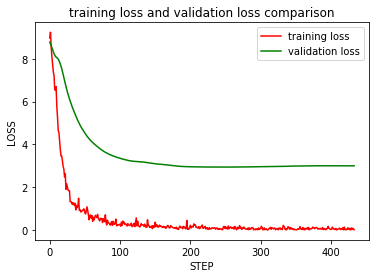

In [8]:
#training loss
x = np.linspace(0, 433, 434)
plt.figure()
plt.title("training loss and validation loss comparison")
plt.xlabel("STEP")
plt.ylabel("LOSS")
plt.plot(x, training_loss,color = 'red',label = 'training loss')
plt.plot(x, validation_loss_step,color = 'green',label = 'validation loss')
plt.legend(loc = 'upper right')
plt.show()

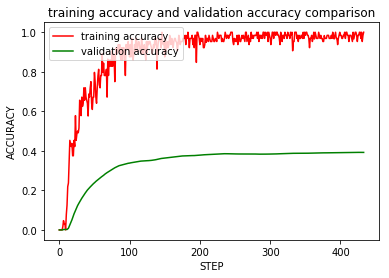

In [9]:
x = np.linspace(0, 433, 434)
plt.figure()
plt.title("training accuracy and validation accuracy comparison")
plt.xlabel("STEP")
plt.ylabel("ACCURACY")
plt.plot(x, training_acu,color = 'red',label = 'training accuracy')
plt.plot(x, validation_acu_step,color = 'green',label = 'validation accuracy')
plt.legend(loc = 'upper left')
plt.show()

## Step 7: Training for improved ResNet with BDR

In [10]:
#model resnet50 used for bdr
model_conv_bdr = torchvision.models.resnet50(pretrained=True)
model_conv_bdr.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
model_conv_bdr.last_linear = nn.Sequential(nn.Dropout(0.6), nn.Linear(in_features=2048, out_features=512, bias=True), nn.SELU(),
                                      nn.Dropout(0.8),  nn.Linear(in_features=512, out_features=7, bias=True))


model_conv_bdr.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_conv_bdr.parameters(), lr=0.0001)

In [11]:
#tranining with BDR
EPOCH = 31

#used for validation
validation_loss = []
validation_acu = []
#used for ploting
training_loss = []
training_acu = []
validation_loss_step = []
validation_acu_step = []
#used for BDR
var = [] 


def bdr(loss,k):

    subset = []
    new_loss = loss.copy()
    remove = []

    for i in range(len(loss)):
        if loss[i] > np.mean(loss):
            subset.append(loss[i])

    for i in range(len(loss)):
        if loss[i] > np.mean(subset) + k*np.std(subset):
            new_loss.remove(loss[i])
            remove.append(i)
            
    return new_loss,remove

for epoch in range(EPOCH):
    for step, (data, target) in enumerate(train_loader):  # batch data, normalize x when iterate train_loader

        data, target = data.cuda(), target.cuda()
        
        model_conv_bdr.train()
        output = model_conv_bdr(data)  # output
        loss = criterion(output, target.long())  # cross entropy loss
        train_pred_y = torch.max(output, 1)[1].data.cpu().numpy()
        train_accuracy = float((train_pred_y == target.data.cpu().numpy()).astype(int).sum()) / float(target.size(0))
        training_loss.append(loss.data.cpu().numpy())
        training_acu.append(train_accuracy)
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients        
        
        # BDR
        if epoch % 1 == 0 and step == 13:
            pattern_loss = []
            for step_bdr, (data_bdr, target_bdr) in enumerate(train_loader_bdr):  # batch data, normalize x when iterate train_loader
                data_bdr, target_bdr = data_bdr.cuda(), target_bdr.cuda()      
                model_conv_bdr.eval()
                output_bdr = model_conv_bdr(data_bdr)  # output
                loss_bdr = criterion(output_bdr, target_bdr.long())
                pattern_loss.append(loss_bdr.data.cpu().numpy())
            print(np.var(pattern_loss))
            var.append(np.var(pattern_loss))
            if epoch == 6 and step == 13:
                new_loss, remove_list = bdr(pattern_loss,1)
                for element in remove_list:
                    image_id = training_set.image_files_list[element]
                    if image_id in train_img_class_dict.keys():
                        del train_img_class_dict[image_id] 
                training_set_new = FaceEmotionDataset(datafolder='Train/Train_Aligned_Faces/Train_all', datatype='train_bdr', transform=data_transforms, labels_dict=train_img_class_dict)
                train_loader = torch.utils.data.DataLoader(training_set_new, batch_size=batch_size, num_workers=num_workers, shuffle=True)
                train_loader_bdr = torch.utils.data.DataLoader(training_set_new, batch_size=1, num_workers=num_workers)
        
        # validation
        if epoch % 1 == 0:
            model_conv_bdr.eval()
            for step, (val_data, val_target) in enumerate(valid_loader):
                
                val_data, val_target = val_data.cuda(), val_target.cuda()
                
                val_output = model_conv_bdr(val_data)
                val_loss = criterion(val_output, val_target.long())  # cross entropy loss
                validation_loss.append(val_loss.data.cpu().numpy())           
                pred_y = torch.max(val_output, 1)[1].data.cpu().numpy()
                validation_accuracy = float((pred_y == val_target.data.cpu().numpy()).astype(int).sum()) / float(val_target.size(0))
                validation_acu.append(validation_accuracy)
            validation_loss_step.append(np.mean(validation_loss))
            validation_acu_step.append(np.mean(validation_acu))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| train accuracy: %.2f' % train_accuracy, '| val loss: %.4f' % np.mean(validation_loss), '| val accuracy: %.2f' % np.mean(validation_acu))


Epoch:  0 | train loss: 9.3477 | train accuracy: 0.00 | val loss: 8.7974 | val accuracy: 0.00
Epoch:  0 | train loss: 8.6073 | train accuracy: 0.00 | val loss: 8.7526 | val accuracy: 0.00
Epoch:  0 | train loss: 8.5452 | train accuracy: 0.00 | val loss: 8.6807 | val accuracy: 0.00
Epoch:  0 | train loss: 8.1354 | train accuracy: 0.03 | val loss: 8.6356 | val accuracy: 0.00
Epoch:  0 | train loss: 7.3944 | train accuracy: 0.02 | val loss: 8.5964 | val accuracy: 0.00
Epoch:  0 | train loss: 7.3108 | train accuracy: 0.00 | val loss: 8.5333 | val accuracy: 0.00
Epoch:  0 | train loss: 7.0018 | train accuracy: 0.02 | val loss: 8.4643 | val accuracy: 0.00
Epoch:  0 | train loss: 6.8282 | train accuracy: 0.00 | val loss: 8.3972 | val accuracy: 0.00
Epoch:  0 | train loss: 6.4194 | train accuracy: 0.03 | val loss: 8.3337 | val accuracy: 0.00
Epoch:  0 | train loss: 6.2757 | train accuracy: 0.08 | val loss: 8.2659 | val accuracy: 0.00
Epoch:  0 | train loss: 5.4464 | train accuracy: 0.14 | val 

Epoch:  6 | train loss: 0.3154 | train accuracy: 0.89 | val loss: 3.6110 | val accuracy: 0.32
Epoch:  6 | train loss: 0.3000 | train accuracy: 0.91 | val loss: 3.5986 | val accuracy: 0.32
Epoch:  6 | train loss: 0.4778 | train accuracy: 0.86 | val loss: 3.5899 | val accuracy: 0.32
Epoch:  6 | train loss: 0.3368 | train accuracy: 0.89 | val loss: 3.5784 | val accuracy: 0.32
Epoch:  6 | train loss: 0.4361 | train accuracy: 0.83 | val loss: 3.5678 | val accuracy: 0.32
Epoch:  6 | train loss: 0.3736 | train accuracy: 0.86 | val loss: 3.5574 | val accuracy: 0.33
Epoch:  6 | train loss: 0.3032 | train accuracy: 0.91 | val loss: 3.5479 | val accuracy: 0.33
Epoch:  6 | train loss: 0.4663 | train accuracy: 0.80 | val loss: 3.5386 | val accuracy: 0.33
Epoch:  6 | train loss: 0.6271 | train accuracy: 0.81 | val loss: 3.5279 | val accuracy: 0.33
Epoch:  6 | train loss: 0.3193 | train accuracy: 0.89 | val loss: 3.5159 | val accuracy: 0.33
0.44571847
Epoch:  6 | train loss: 0.4087 | train accuracy: 

Epoch:  12 | train loss: 0.0674 | train accuracy: 1.00 | val loss: 3.0136 | val accuracy: 0.37
Epoch:  12 | train loss: 0.1824 | train accuracy: 0.97 | val loss: 3.0107 | val accuracy: 0.37
Epoch:  12 | train loss: 0.0717 | train accuracy: 0.98 | val loss: 3.0084 | val accuracy: 0.37
Epoch:  12 | train loss: 0.1385 | train accuracy: 0.94 | val loss: 3.0068 | val accuracy: 0.37
Epoch:  12 | train loss: 0.0942 | train accuracy: 0.97 | val loss: 3.0045 | val accuracy: 0.37
Epoch:  12 | train loss: 0.1657 | train accuracy: 0.95 | val loss: 3.0031 | val accuracy: 0.37
Epoch:  12 | train loss: 0.1020 | train accuracy: 0.97 | val loss: 3.0009 | val accuracy: 0.37
0.068560325
Epoch:  12 | train loss: 0.4730 | train accuracy: 0.86 | val loss: 3.0000 | val accuracy: 0.37
Epoch:  13 | train loss: 0.0630 | train accuracy: 0.98 | val loss: 2.9985 | val accuracy: 0.37
Epoch:  13 | train loss: 0.1661 | train accuracy: 0.94 | val loss: 2.9966 | val accuracy: 0.37
Epoch:  13 | train loss: 0.1288 | trai

Epoch:  18 | train loss: 0.0565 | train accuracy: 0.98 | val loss: 2.9154 | val accuracy: 0.38
Epoch:  18 | train loss: 0.0328 | train accuracy: 1.00 | val loss: 2.9151 | val accuracy: 0.38
Epoch:  18 | train loss: 0.0416 | train accuracy: 1.00 | val loss: 2.9149 | val accuracy: 0.38
Epoch:  18 | train loss: 0.0623 | train accuracy: 0.98 | val loss: 2.9140 | val accuracy: 0.38
Epoch:  18 | train loss: 0.1564 | train accuracy: 0.94 | val loss: 2.9143 | val accuracy: 0.38
0.0777668
Epoch:  18 | train loss: 0.2346 | train accuracy: 0.91 | val loss: 2.9146 | val accuracy: 0.38
Epoch:  19 | train loss: 0.0634 | train accuracy: 0.98 | val loss: 2.9153 | val accuracy: 0.38
Epoch:  19 | train loss: 0.0673 | train accuracy: 0.97 | val loss: 2.9148 | val accuracy: 0.38
Epoch:  19 | train loss: 0.1104 | train accuracy: 0.95 | val loss: 2.9151 | val accuracy: 0.38
Epoch:  19 | train loss: 0.1072 | train accuracy: 0.97 | val loss: 2.9156 | val accuracy: 0.38
Epoch:  19 | train loss: 0.1508 | train 

Epoch:  24 | train loss: 0.0162 | train accuracy: 1.00 | val loss: 2.9340 | val accuracy: 0.39
Epoch:  24 | train loss: 0.0606 | train accuracy: 0.98 | val loss: 2.9341 | val accuracy: 0.39
Epoch:  24 | train loss: 0.0673 | train accuracy: 0.98 | val loss: 2.9341 | val accuracy: 0.39
0.04650809
Epoch:  24 | train loss: 0.0452 | train accuracy: 0.97 | val loss: 2.9340 | val accuracy: 0.39
Epoch:  25 | train loss: 0.1785 | train accuracy: 0.95 | val loss: 2.9341 | val accuracy: 0.39
Epoch:  25 | train loss: 0.0607 | train accuracy: 0.97 | val loss: 2.9336 | val accuracy: 0.39
Epoch:  25 | train loss: 0.0475 | train accuracy: 0.98 | val loss: 2.9336 | val accuracy: 0.39
Epoch:  25 | train loss: 0.0878 | train accuracy: 0.97 | val loss: 2.9330 | val accuracy: 0.39
Epoch:  25 | train loss: 0.0336 | train accuracy: 1.00 | val loss: 2.9328 | val accuracy: 0.39
Epoch:  25 | train loss: 0.0455 | train accuracy: 0.98 | val loss: 2.9327 | val accuracy: 0.39
Epoch:  25 | train loss: 0.0614 | train

Epoch:  30 | train loss: 0.0367 | train accuracy: 0.98 | val loss: 2.9335 | val accuracy: 0.39
0.06764038
Epoch:  30 | train loss: 0.0305 | train accuracy: 1.00 | val loss: 2.9338 | val accuracy: 0.39


## Step 8: Evaluating the Results of improved ResNet with BDR

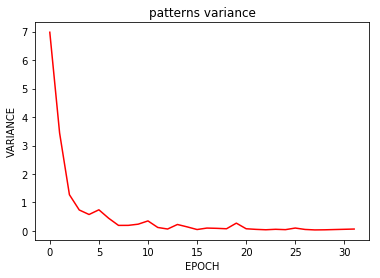

In [19]:
# variance distribution used for searching the start point of the BDR
x = np.linspace(0, 31, 31, dtype=int)
plt.figure()
plt.title("patterns variance")
plt.xlabel("EPOCH")
plt.ylabel("VARIANCE")
plt.plot(x, var,color = 'red',label = 'training loss')
plt.show()

In [20]:
# remove list by using BDR
print(remove_list)
print(len(training_set))
print(len(train_img_class_dict))
print(len(training_set_new.labels))

[43, 51, 129, 146, 287, 291, 319, 320, 337, 378, 388, 413, 443, 491, 509, 544, 582, 628, 643, 654, 668, 758, 818, 846]
891
867
867


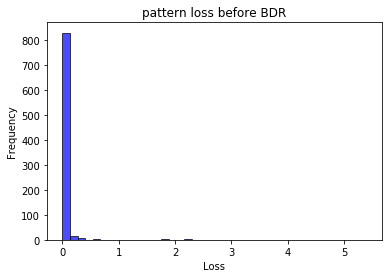

In [22]:
#before bdr
plt.figure()
plt.hist(pattern_loss, bins=40, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.title("pattern loss before BDR")
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.show()

0.16088533


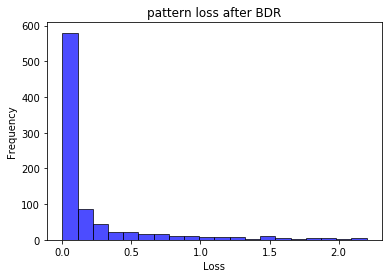

In [23]:
# after bdr
print(np.var(new_loss))
plt.figure()
plt.hist(new_loss, bins=20, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.title("pattern loss after BDR")
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.show()

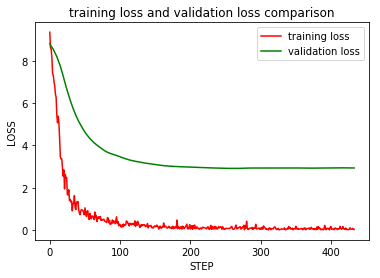

In [24]:
#training and validation loss
x = np.linspace(0, 433, 434)
plt.figure()
plt.title("training loss and validation loss comparison")
plt.xlabel("STEP")
plt.ylabel("LOSS")
plt.plot(x, training_loss,color = 'red',label = 'training loss')
plt.plot(x, validation_loss_step,color = 'green',label = 'validation loss')
plt.legend(loc = 'upper right')
plt.show()

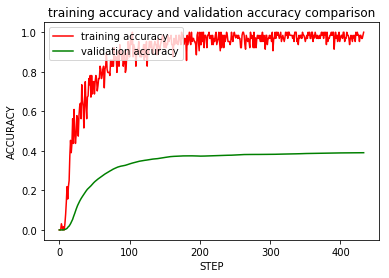

In [25]:
#training and validation loss
x = np.linspace(0, 433, 434)
plt.figure()
plt.title("training accuracy and validation accuracy comparison")
plt.xlabel("STEP")
plt.ylabel("ACCURACY")
plt.plot(x, training_acu,color = 'red',label = 'training accuracy')
plt.plot(x, validation_acu_step,color = 'green',label = 'validation accuracy')
plt.legend(loc = 'upper left')
plt.show()

## Testing 

In [27]:
#test

#used for test
accuracies = []
accuracies_bdr = []
model_conv.eval()
model_conv_bdr.eval()
for batch_i, (test_data, test_target) in enumerate(test_loader):
    test_data, test_target = test_data.cuda(), test_target.cuda()
    test_output = model_conv(test_data)
    test_output_bdr = model_conv_bdr(test_data)
    pred_y = torch.max(test_output, 1)[1].data.cpu().numpy()
    pred_y_bdr = torch.max(test_output_bdr, 1)[1].data.cpu().numpy()
    print("test results without BDR")
    print("------------------------------------------------------------")
    print(pred_y)
    print(test_target.data.cpu().numpy())
    print("test results with BDR")
    print("------------------------------------------------------------")
    print(pred_y_bdr)
    print(test_target.data.cpu().numpy())
    test_accuracy = float((pred_y == test_target.data.cpu().numpy()).astype(int).sum()) / float(test_target.size(0))
    test_accuracy_bdr = float((pred_y_bdr == test_target.data.cpu().numpy()).astype(int).sum()) / float(test_target.size(0))
    accuracies.append(test_accuracy)
    accuracies_bdr.append(test_accuracy_bdr)
print('test accuracy without BDR: %.2f' % np.mean(accuracies))
print('test accuracy with BDR: %.2f' % np.mean(accuracies_bdr))


test results without BDR
------------------------------------------------------------
[0 6 4 1 5 4 4 4 3 4 0 0 3 0 4 3 4 4 2 4 4 4 5 0 3 3 3 4 4 0 0 4 4 4 0 4 0
 4 2 6 3 5 3 6 3 5 2 4 5 3 4 1 5 3 4 3 4 4 0 4 3 4 0 4]
[5 2 4 0 5 4 0 5 3 4 2 2 3 6 4 3 1 4 6 5 0 2 5 1 5 4 5 3 1 0 0 4 4 0 3 4 2
 5 0 0 4 4 4 4 3 5 5 1 1 3 5 5 6 3 4 3 4 6 0 6 4 4 5 0]
test results with BDR
------------------------------------------------------------
[4 6 0 1 6 4 0 3 3 4 0 0 3 0 4 3 4 4 0 5 0 0 5 0 4 3 4 4 4 0 0 1 4 2 0 4 0
 4 3 0 0 3 3 4 3 3 2 1 0 3 4 3 5 4 4 3 5 3 0 1 5 4 0 0]
[5 2 4 0 5 4 0 5 3 4 2 2 3 6 4 3 1 4 6 5 0 2 5 1 5 4 5 3 1 0 0 4 4 0 3 4 2
 5 0 0 4 4 4 4 3 5 5 1 1 3 5 5 6 3 4 3 4 6 0 6 4 4 5 0]
test results without BDR
------------------------------------------------------------
[6 6 2 0 3 0 0 4 5 0 3 4 3 3 4 4 2 4 2 3 4 0 0 0 0 0 5 5 6 3 4 3 2 1 6 3 5
 5 3 4 0 3 0 3 5 0 4 4 4 3 6 2 6 4 4 4 4 0 3 5 0 6 4 3]
[2 6 1 0 3 3 6 6 5 2 3 4 3 3 4 3 6 6 5 4 5 5 2 0 0 3 0 5 6 2 1 3 4 2 6 3 6
 3 1 2 0 2 3 6 